#  <span style="color: blue;">人臉偵測與辨識 </span>

臉部辨識技術有越來越多的應用。這個單元將使用MTCNN模型來偵測人臉，用FaceNet提取臉部特徵，相關應用有：
 + 人臉身份驗証（確認是否為某人）(Face Authentication)
 + 人臉身份辨識（在多人中識別出是哪一個人）(Face Identification)
 + 人臉分群 (Face Cluster)
 + 人臉搜索 (Face Search)
 + 人臉追蹤 (Face Tracking)

不過，近來對生物特徵隱私權（如人臉特徵）的議題也越來越受重視，如下面報導。
+ <a href="https://udn.com/news/story/6811/4317212?from=udn-ch1_breaknews-1-0-news" target="_blank" title="生物特徵隱私權受矚">2020-02-02聯合報：生物特徵隱私權受矚</a>
+ <a href="https://udn.com/news/story/6812/4293443?from=udn-referralnews_ch2artbottom" target="_blank" title="生物特徵隱私權受矚">2020-01-17聯合報：歐盟公共場所擬禁臉部辨識3到5年</a>
+  <a href="https://www.youtube.com/watch?v=JhvhtzJAEDc" target="_blank" title="Facial recognition">Engadget, Facial recognition is everywhere, but are we ready for it?</a>



## MTCNN人臉偵測模型
+ 這個模型完成下面工作
  + 人臉偵測。
  + 找到準確的人臉框。
  + 會輸出左眼、右眼、鼻子、左嘴角、右嘴角等5個臉部地標點。
<pre>
[
{'box': [201, 83, 221, 289],
 'confidence': 0.9999898672103882,
 'keypoints': {
  'left_eye': (264, 201),
  'right_eye': (368, 204),
  'nose': (317, 267),
  'mouth_left': (273, 308),
  'mouth_right': (349, 314)}}
]
</pre>
+ 偵測步驟: 使用3個人工神經網路:P-Net、R-Net、O-Net分別進行下面工作:
     1. 使用P-Net找出一堆人臉候選框，並使用NMS(nonmaximum suppression)合併高度重疊之人臉候選框，然後進行步驟2。
     1. 使用R-Net刪除步驟1找到的錯誤候選框，並使用NMS合併高度重疊之人臉候選框。
     1. 使用O-Net刪除步驟2找到的錯誤候選框，使用NMS合併高度重疊之人臉候選框，並且找出5個臉部地標點。
<div>
    <img src="attachment:mtcnn.png" width="300">
</div>
+ K. Zhang, Z. Zhang, Z. Li and Y. Qiao, "Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks," in IEEE Signal Processing Letters, vol. 23, no. 10, pp. 1499-1503, Oct. 2016.
<a href="http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7553523&isnumber=7539715" target="_blank" title="MTCNN">doi: 10.1109/LSP.2016.2603342</a>
  + 安裝
  <pre>
  pip install mtcnn
  </pre>
  
  
## FaceNet人臉特徵提取模型
+ FaceNet對人臉影像提取用來度量人臉間相似度的表示特徵（一個128維度向量），此特徵表示又稱人臉嵌入(face embedding)。
+ 人臉嵌入具備有相似臉間距離小，不相同的臉間距離大的特性。
<div>
    <img src="attachment:facenet.png" width="400">
</div>

+ 下面用的FaceNet是用<a href="https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/" target="_blank" title="MS-Celeb-1M dataset">MS-Celeb-1M dataset</a>這個資料集訓練出來的。
  + F. Schroff, D. Kalenichenko and J. Philbin, "FaceNet: A unified embedding for face recognition and clustering," 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, 2015, pp. 815-823. doi: 10.1109/CVPR.2015.7298682;<a href="https://arxiv.org/abs/1503.03832" target="_blank" title="FaceNet">arXiv:1503.03832</a>
+ <a href="https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/" target="_blank" title="FaceNet">FaceNet使用範例</a>


In [15]:
try:
    import mtcnn
except ImportError:
    # Install mtcnn if not present
    import sys
    !{sys.executable} -m pip install mtcnn
    import mtcnn

import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image
import cv2
import numpy as np
import pickle

try:
  from keras_facenet import FaceNet
  facenet = FaceNet()
except:
  !pip install keras_facenet
  from keras_facenet import FaceNet
  facenet = FaceNet()

detector = mtcnn.MTCNN()

637512/637512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


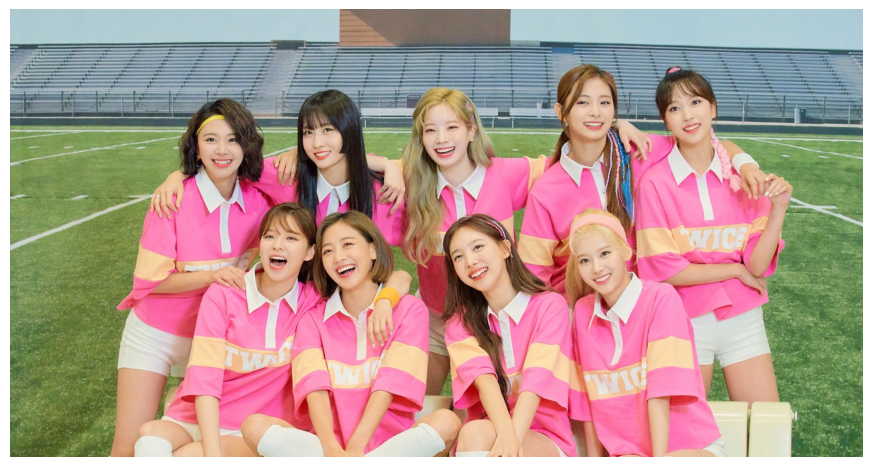

In [2]:
# load image from file
#url  ='https://www.teepr.com/wp-content/uploads/2019/07/%E8%9E%A2%E5%B9%95%E5%BF%AB%E7%85%A7-2019-07-15-%E4%B8%8B%E5%8D%883.42.39%E6%8B%B7%E8%B2%9D.jpg'
url  ='https://a.ksd-i.com/a/2020-01-01/123159-803538.jpg'
#url = 'http://img1.cache.netease.com/ent/2014/8/4/20140804091400aaef0_550.jpg'
name = url.split('/')[-1]
filename = tf.keras.utils.get_file(name,origin=url)
#
image = tf.keras.preprocessing.image.load_img(filename)
# convert to array
pixels = tf.keras.preprocessing.image.img_to_array(image)

#show image
plt.figure(figsize=(pixels.shape[1]*6//pixels.shape[0],6))
plt.imshow(pixels/255)
plt.axis(False)
plt.show()

In [3]:
# detect faces in the image
results = detector.detect_faces(pixels)

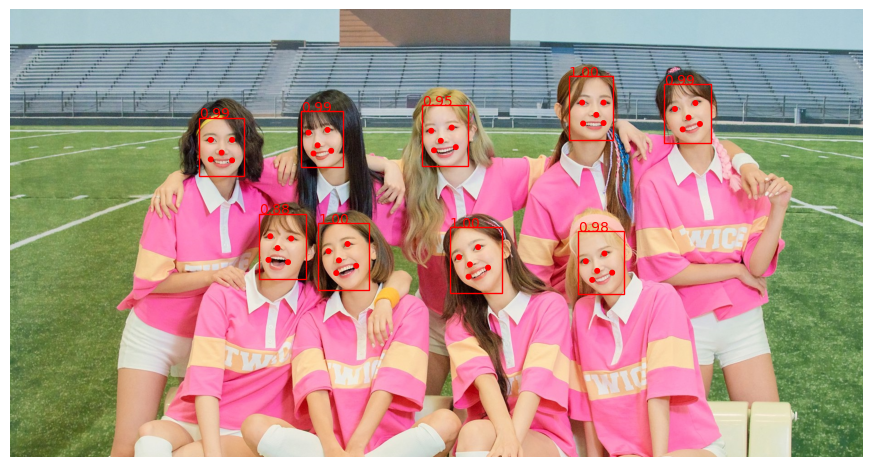

In [4]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# show detected faces
plt.figure(figsize=(pixels.shape[1]*6//pixels.shape[0],6))
plt.imshow(pixels/255)
plt.axis(False)
ax = plt.gca()

for b in results:
    x1, y1, width, height = b['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    plt.text(x1,y1,'{:.2f}'.format(b['confidence']),color='red')
    ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec='red',alpha=1, fill=None))
    ax.add_patch(mpatches.Circle(b['keypoints']['mouth_left'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['mouth_right'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['left_eye'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['right_eye'],5,color='red'))
    ax.add_patch(mpatches.Circle(b['keypoints']['nose'],5,color='red'))
plt.show()

In [18]:
def get_face_embedding(facenet, face_image):
    """
    Using the FaceNet model from keras_facenet to extract features of the faces
    """
    # normalize the image
    face_image = (face_image - tf.math.reduce_mean(face_image)) / tf.math.reduce_std(face_image)

    # convert to numpy array
    if hasattr(face_image, 'numpy'):
        face_array = face_image.numpy()
    else:
        face_array = np.array(face_image)

    # ensure the images are float32 and within [0, 255] (the expected form of keras_facenet)
    if face_array.max() <= 1.0:
        face_array = face_array * 255.0
    face_array = face_array.astype(np.float32)

    # increase the dimension of the batch
    face_batch = np.expand_dims(face_array, axis=0)

    # embedding the face batch
    embedding = facenet.embeddings(face_batch)

    # L2 normalization
    embedding = embedding / np.linalg.norm(embedding)

    return embedding

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


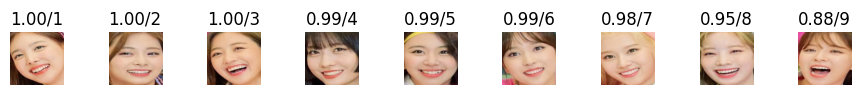

In [19]:
# extract detected faces and calculate the embedding
plt.figure(figsize=(10,(len(results)+9)//10))
face_embedding = []
face_img       = []
for idx,b in enumerate(results):
    plt.subplot((len(results)+9)//10,10,idx+1)
    x1, y1, width, height = b['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    face = cv2.resize(pixels[y1:y2,x1:x2],(160,160)).astype('float32')
    face_img.append(face)
    # get embedding
    embedding = get_face_embedding(facenet,face)

    face_embedding.append(embedding)

    plt.imshow(face_img[-1]/255)
    plt.title('{:.2f}/{}'.format(b['confidence'],idx+1))
    plt.axis(False)
plt.tight_layout()
plt.show()

face_embedding = np.vstack(face_embedding)

### 人臉分群
使用Agglomerative Clustering搭配ward linkage，將人臉分三群。

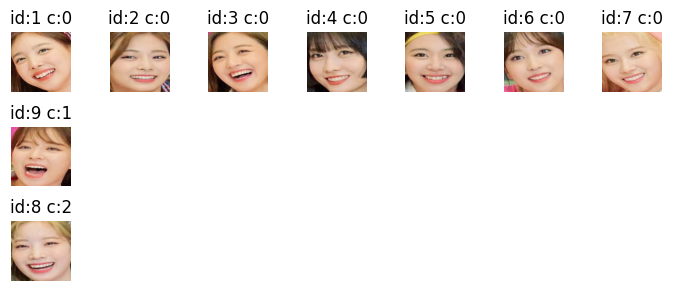

In [20]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(face_embedding)

## show the result of classification
index = []
row   = [0]
for c in range(clustering.n_clusters_):
    idx = np.nonzero(clustering.labels_==c)[0]
    index.append(idx)
    row.append(row[-1]+(idx.size+9)//10)
total_rows = row[-1]

plt.figure(figsize=(10,total_rows))
for c in range(clustering.n_clusters_):
    for idx,face_id in enumerate(index[c]):
        plt.subplot(total_rows,10,row[c]*10+idx+1)
        plt.axis(False)
        plt.title('id:{} c:{}'.format(face_id+1,c))
        plt.imshow(face_img[face_id]/255)
plt.tight_layout()
plt.show()

### 人臉辨識
訓練人臉影像安排於如下資料匣，每個最底層(如ben_afflek)資料匣代表一個人(一類別)，內含這個人的影像。
<table style="width:600">
  <tr>
    <td align="center"><img src="attachment:train_folder.png" width="150"></td>
    <td align="text-align:left"><img src="attachment:train_folder_2.png" width="400"></td>
  </tr>
</table>

In [31]:
def generate_examples(gendata):
    train_x = []
    train_y = []
    for idx, (filename, y) in enumerate(zip(gendata.filenames,gendata.classes)):
        x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(gendata.directory,filename)))
        results = detector.detect_faces(x_img)
        if len(results)>0:
            x1, y1, width, height = results[0]['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            face = tf.image.resize(x_img[y1:y2,x1:x2],(160,160))
            embedding = get_face_embedding(facenet,face)
            train_x.append(embedding)
            train_y.append(y)
    return tf.concat(train_x,axis=0),tf.constant(np.array(train_y))

def def_face_recognition_model(class_indices, embedding_dim=None):
    # if not providing the dimension of embedding，use the default dimensions of the output of keras_facenet
    if embedding_dim is None:
        embedding_dim = 512

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((embedding_dim,)))
    model.add(tf.keras.layers.Dense(len(class_indices), activation='softmax'))
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.person_name = {v:k for k,v in class_indices.items()}
    return model

def face_recognition_robust(facenet, classifier, face_image):
    try:
        embedding = get_face_embedding(facenet, face_image)
        prob = classifier.predict(embedding, verbose=0)
        predicted_class = tf.math.argmax(prob, axis=1).numpy()[0]
        confidence = tf.math.reduce_max(prob).numpy()

        print(f"Predicted class: {predicted_class}, type: {type(predicted_class)}")
        print(f"Confidence: {confidence:.3f}")
        print(f"Available classes: {list(classifier.person_name.keys())}")

        # find the name of the person
        name = None
        for key, value in classifier.person_name.items():
            if int(key) == int(predicted_class):
                name = value
                break

        if name is None:
            name = f"Unknown_Class_{predicted_class}"
            print(f"Warning: No name found for class {predicted_class}")

        return name, confidence

    except Exception as e:
        print(f"Error in face recognition: {e}")
        return "Error", 0.0

def face_recognition(facenet, classifier, face_image):
    name, _ = face_recognition_robust(facenet, classifier, face_image)
    return name

In [25]:
import kagglehub
import shutil
import os

# downloading the dataset
path = kagglehub.dataset_download("dansbecker/5-celebrity-faces-dataset")
print(f"Downloaded to: {path}")

# copy the dataset to Colab workspace
destination = "./5-celebrity-faces-dataset/"
if os.path.exists(destination):
    shutil.rmtree(destination)
shutil.copytree(path, destination)

print(f"Dataset copied to: {destination}")
print("Files in dataset:")
for root, dirs, files in os.walk(destination):
    level = root.replace(destination, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")

Downloaded to: /kaggle/input/5-celebrity-faces-dataset
Dataset copied to: ./5-celebrity-faces-dataset/
Files in dataset:
/
val/
  mindy_kaling/
    httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg
    httpdbrbzkkbdsdcloudfrontnetwpcontentuploadsMindyKalingjpg.jpg
    httpcdncdnjustjaredcomwpcontentuploadsheadlinesmindykalingcomedypilotjpg.jpg
    httpcdnpastemagazinecomwwwarticlesmindyprojectjpg.jpg
    httpcdnpastemagazinecomwwwarticlesmindykalingndbookjpg.jpg
  jerry_seinfeld/
    httpcdnssninsidercomwpcontentuploadsjerryseinfeldxjpg.jpg
    httpcdncdnjustjaredcomwpcontentuploadsheadlinesjerryseinfeldmakesbrianwilliamsjokejpg.jpg
    httpblognjcomentertainmentimpactcelebritiesmediumjerrybjpg.jpg
    httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIwNjANjMMDINzIxNjcjpg.jpg
    httpaurorasblogcomwpcontentuploadsjerryseinfeldpublicityshotjpg.jpg
  madonna/
    httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg
    httpcdncd

In [27]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


dataset_folder = './5-celebrity-faces-dataset/'
#dataset_folder = './face/'
#train_generator = train_datagen.flow_from_directory('./5-celebrity-faces-dataset/train',batch_size=1)
#valid_generator = train_datagen.flow_from_directory('./5-celebrity-faces-dataset/val',batch_size=1)
train_generator = train_datagen.flow_from_directory(dataset_folder +'train',batch_size=1)
valid_generator = train_datagen.flow_from_directory(dataset_folder +'val',batch_size=1)

train_x,train_y = generate_examples(train_generator)
valid_x,valid_y = generate_examples(valid_generator)

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━

In [30]:
model = def_face_recognition_model(train_generator.class_indices)
history = model.fit(train_x,train_y,batch_size=13,validation_data=(valid_x,valid_y),epochs=30,verbose=1)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.2095 - loss: 1.6109 - val_accuracy: 0.2000 - val_loss: 1.6145
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1967 - loss: 1.6122 - val_accuracy: 0.2000 - val_loss: 1.6136
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2361 - loss: 1.6094 - val_accuracy: 0.2000 - val_loss: 1.6142
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2261 - loss: 1.6022 - val_accuracy: 0.2000 - val_loss: 1.6169
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2652 - loss: 1.6037 - val_accuracy: 0.2000 - val_loss: 1.6198
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1721 - loss: 1.6175 - val_accuracy: 0.2000 - val_loss: 1.6226
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1962 - loss: 1.5998 - val_accuracy: 0.2000 - val_loss: 1.6256
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1922 - loss: 1.6033 - val_accuracy: 0.2000 - val_loss: 1.6279


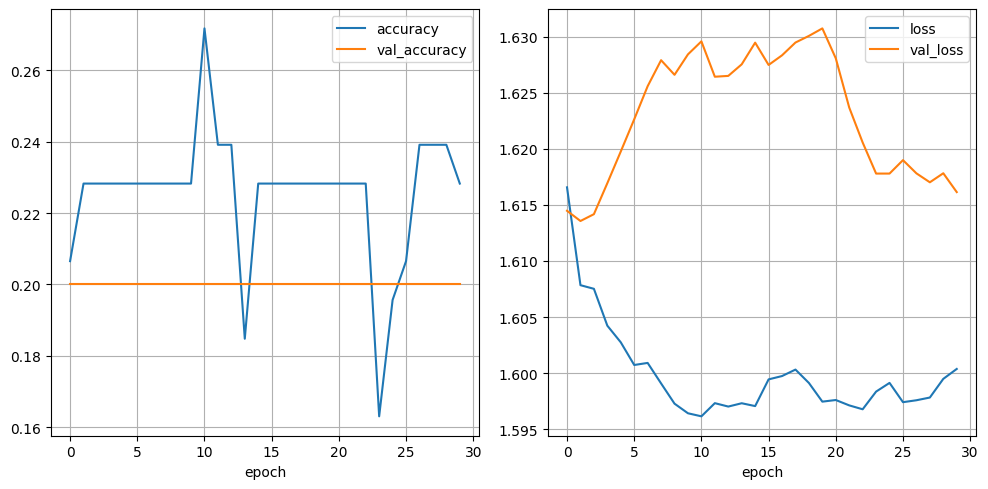

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.axis(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.grid(True)
plt.axis(True)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

#### 儲存模型
之後使用此模型只要載入即可，不需要再重新訓練。

In [34]:
import json

def save_face_recognition_model(model, model_name='face_model'):
    """
    安全地儲存人臉識別模型和相關資料
    """
    try:
        # 1. store the weight and structure of the model
        model_path = f'{model_name}.keras'
        model.save(model_path)
        print(f"✓ Model saved as {model_path}")

        # 2. store the person_name dictionary
        if hasattr(model, 'person_name'):
            names_path = f'{model_name}_names.json'
            with open(names_path, 'w') as f:
                json.dump(model.person_name, f, indent=2)
            print(f"✓ Person names saved as {names_path}")

        # 3. store the information of the model
        info_path = f'{model_name}_info.json'
        model_info = {
            'input_shape': model.input_shape,
            'output_shape': model.output_shape,
            'num_classes': len(model.person_name) if hasattr(model, 'person_name') else 0,
            'embedding_dim': model.input_shape[1] if model.input_shape else None
        }
        with open(info_path, 'w') as f:
            json.dump(model_info, f, indent=2)
        print(f"✓ Model info saved as {info_path}")

        return True

    except Exception as e:
        print(f"✗ Error saving model: {e}")
        return False

In [35]:
save_face_recognition_model(model, 'face_model')

✓ Model saved as face_model.keras
✓ Person names saved as face_model_names.json
✓ Model info saved as face_model_info.json


True

#### 載入模型

In [36]:
import json

def load_face_recognition_model(model_name='face_model'):
    try:
        # 1. load the model
        model_path = f'{model_name}.keras'
        if os.path.exists(model_path):
            cmodel = tf.keras.models.load_model(model_path)
            print(f"✓ Model loaded from {model_path}")
        else:
            # try to load the model in .h5 form
            model_path = f'{model_name}.h5'
            cmodel = tf.keras.models.load_model(model_path)
            print(f"✓ Model loaded from {model_path}")

        # 2. load person_name dictionary
        names_path = f'{model_name}_names.json'
        if os.path.exists(names_path):
            with open(names_path, 'r') as f:
                cmodel.person_name = json.load(f)
            print(f"✓ Person names loaded from {names_path}")
        else:
            # try to load pickle form
            pickle_path = f'{model_name}.pickle'
            with open(pickle_path, 'rb') as f:
                cmodel.person_name = pickle.load(f)
            print(f"✓ Person names loaded from {pickle_path}")

        return cmodel

    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return None

In [37]:
cmodel = load_face_recognition_model('face_model')
if cmodel:
    print("Model loaded successfully!")
    print(f"Number of classes: {len(cmodel.person_name)}")
    print(f"Classes: {list(cmodel.person_name.values())}")

✓ Model loaded from face_model.keras
✓ Person names loaded from face_model_names.json
Model loaded successfully!
Number of classes: 5
Classes: ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# 檢查並修正 person_name 字典
def fix_person_name_dict(model):
    """
    修正 person_name 字典的鍵類型問題
    """
    if hasattr(model, 'person_name'):
        print("Original person_name:")
        print(model.person_name)

        # ensure all the keys are integer
        fixed_dict = {}
        for key, value in model.person_name.items():
            fixed_dict[int(key)] = value

        model.person_name = fixed_dict
        print("Fixed person_name:")
        print(model.person_name)

    return model

# fix the loaded model
cmodel = fix_person_name_dict(cmodel)

Original person_name:
{'0': 'ben_afflek', '1': 'elton_john', '2': 'jerry_seinfeld', '3': 'madonna', '4': 'mindy_kaling'}
Fixed person_name:
{0: 'ben_afflek', 1: 'elton_john', 2: 'jerry_seinfeld', 3: 'madonna', 4: 'mindy_kaling'}


Model has 5 classes: ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
Processing: madonna/httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg
Found 1 faces
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Face 1: jerry_seinfeld


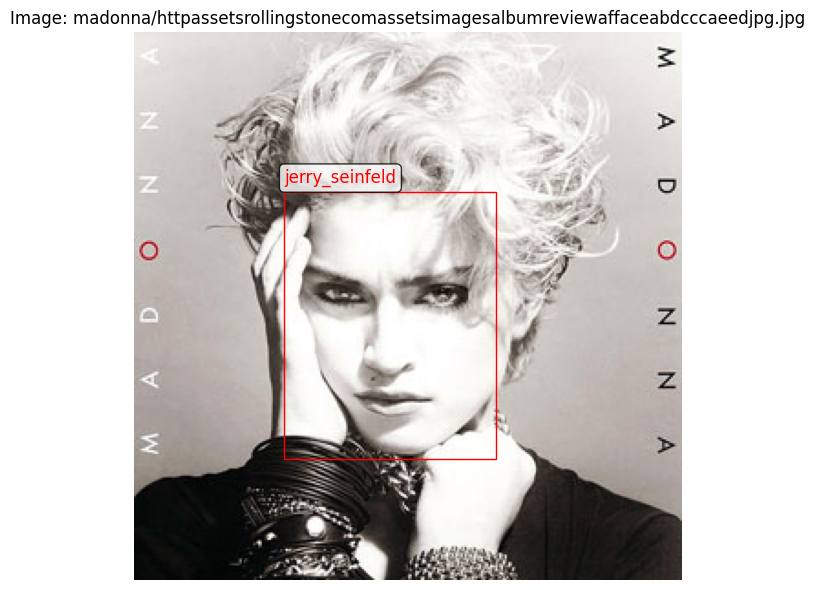

Processing: elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnemmysperformancewatchnowjpg.jpg
Found 1 faces
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Face 1: jerry_seinfeld


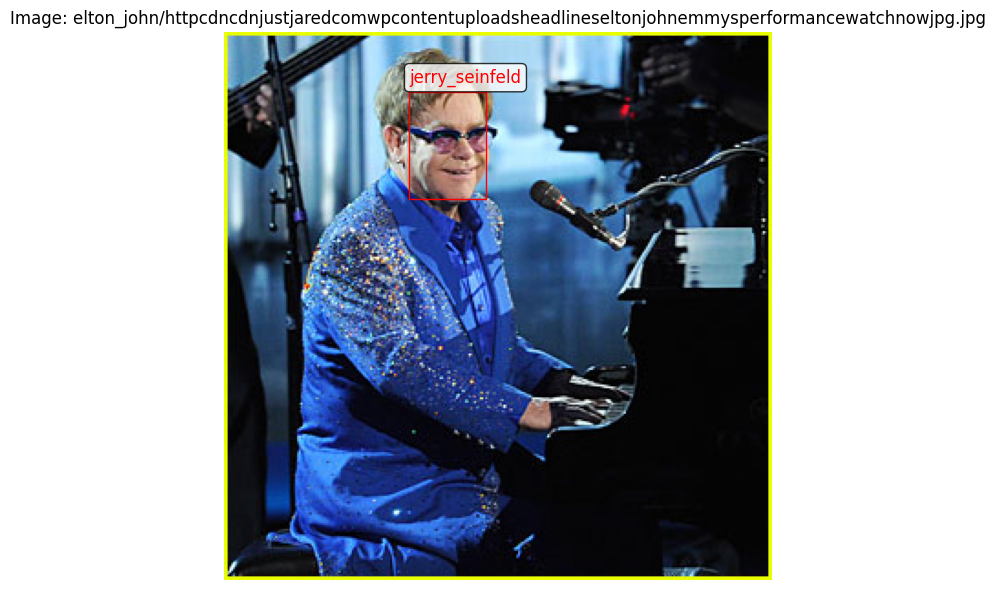

Processing: elton_john/httpcdncdnjustjaredcomwpcontentuploadsheadlineseltonjohnsupportsbrucejennerstransitiontowomanjpg.jpg
Found 1 faces
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Face 1: jerry_seinfeld


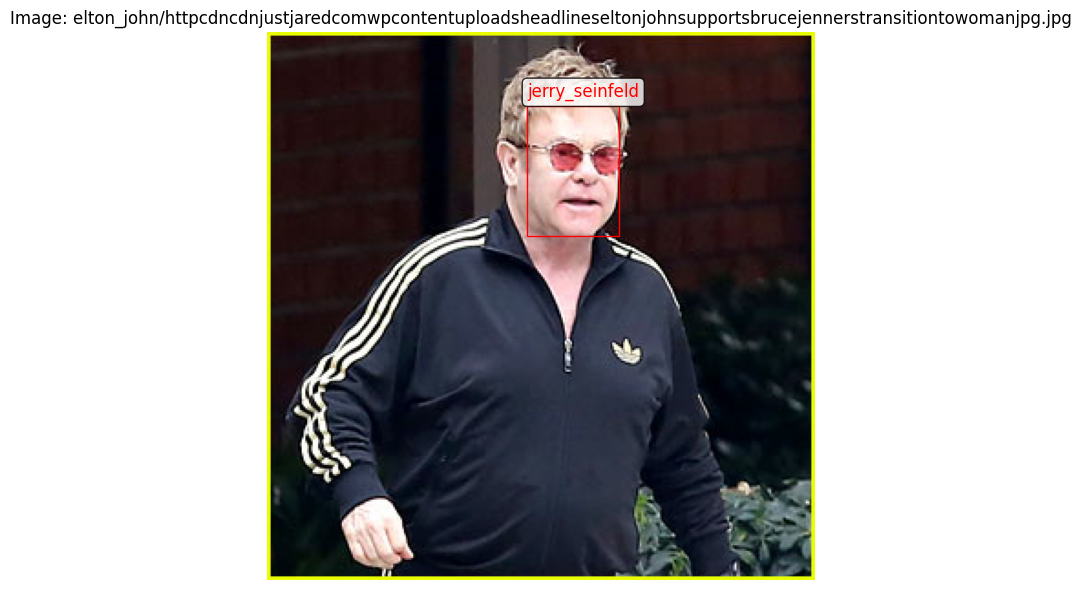

In [40]:
import matplotlib.patches as mpatches

if not hasattr(cmodel, 'person_name'):
    print("Error: Model doesn't have person_name attribute")
else:
    print(f"Model has {len(cmodel.person_name)} classes: {list(cmodel.person_name.values())}")

for r_idx in np.random.permutation(len(valid_generator.filenames))[:3]:  # only plot 3 pictures to test
    try:
        # load the image file
        filename = valid_generator.filenames[r_idx]
        print(f"Processing: {filename}")

        x_img = tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(os.path.join(valid_generator.directory, filename))
        )

        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        plt.imshow(x_img/255)
        plt.title(f"Image: {filename}")

        # detect the face
        results = detector.detect_faces(x_img)
        print(f"Found {len(results)} faces")

        # plot the detected face area
        for i, b in enumerate(results):
            x1, y1, width, height = b['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height

            face = tf.image.resize(x_img[y1:y2, x1:x2], (160, 160))

            try:
                name = face_recognition(facenet, cmodel, face)
                print(f"Face {i+1}: {name}")
            except Exception as e:
                print(f"Error recognizing face {i+1}: {e}")
                name = "Error"

            ax.add_patch(mpatches.Rectangle((x1, y1), width, height, ec='red', alpha=1, fill=None))
            plt.text(x1, y1-5, name, color='red', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.axis(False)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing image {filename}: {e}")
        continue